In [1]:
import sys, os
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from scipy.stats import bayes_mvs as bayesest
import time

from PyEcoLib.simulator import Simulator



%matplotlib inline

In [2]:
mean_size = 3 # micron
doubling_time = 18 #min
tmax = 180 #min
sample_time = 2 #min
div_steps = 10
ncells = 5000

In [3]:
gr = np.log(2)/doubling_time 

In [4]:
if not os.path.exists('./figures'):
    os.makedirs('./figures')
if not os.path.exists('./data'):
    os.makedirs('./data')

In [5]:
sim = Simulator(ncells=ncells, gr = gr, sb=mean_size, steps = div_steps, lamb = 2)

 ___    __     __   _______    ______    _____    __       ___   _____
|  _ \  \  \  |  | |  _____|  /  ____|  / ___ \  |  |     |   | |  __ \
| | \ |  \  \ |  | | |       | /       | /   \ | |  |     |___| | |  \ |
| |_/ /   \  \|  | | |___    | |       | |   | | |  |      ___  | |__/ /
|  __/     \__   | |  ___|   | |       | |   | | |  |     |   | |  __  \
| |           /  / | |       | |       | |   | | |  |     |   | | |  \  |
| |       ___/  /  | |_____  | \_____  | \___/ | |  |___  |   | | |__/  |
|_|      |_____/   |_______|  \______|  \_____/  |______| |___| |______/
Cells initialized


In [6]:
start = time.time()
tmax=10*doubling_time
sim.divstrat(tmax = tmax, sample_time = 0.1*doubling_time, nameDSM = "./data/dataDSM.csv")
print('It took', np.int(time.time()-start), 'seconds.')

Cells initialized
10%
20%
29%
39%
49%
59%
69%
79%
90%
100%
It took 12 seconds.


In [7]:
start = time.time()
tmax=10*doubling_time
sim.szdyn(tmax = tmax, sample_time= 0.1*doubling_time, nameCRM = "./data/dataCRM.csv")
print('It took', np.int(time.time()-start), 'seconds.')

Cells initialized
1%
10%
20%
30%
40%
50%
60%
70%
80%
90%
100%
It took 7 seconds.


In [8]:
start = time.time()
sim.szdynFSP(tmax = tmax, nameFSP = "./data/dataFSP.csv")
print('It took', np.int(time.time()-start), 'seconds.')

It took 71 seconds.


In [9]:
data2=pd.read_csv("./data/dataDSM.csv")
data2=data2[data2.time>5*doubling_time]

quantnumber=5
pvadd2=data2
CV2d=[]
delt=[]
sb=[]
    
errcv2d=[]
errdelt=[]
errsb=[]
for i in range(quantnumber):
    lperv0=np.percentile(pvadd2.S_b,i*100/quantnumber)
    hperv0=np.percentile(pvadd2.S_b,(i+1)*100/quantnumber)
    quanta1=pvadd2[pvadd2.S_b>lperv0]
    quanta2=quanta1[quanta1.S_b<hperv0]     
    mean_cntr, var_cntr, std_cntr = bayesest((quanta2.S_d-quanta2.S_b)/np.mean(pvadd2.S_d-pvadd2.S_b),alpha=0.95)
    meanv0_cntr, varv0_cntr, stdv0_cntr = bayesest(quanta2.S_b/np.mean(pvadd2.S_b),alpha=0.95)
    CV2d.append(var_cntr[0]/mean_cntr[0]**2)
    delt.append(mean_cntr[0])
    sb.append(meanv0_cntr[0])
    errv=(var_cntr[1][1]-var_cntr[0])/mean_cntr[0]**2+2*(mean_cntr[1][1]-mean_cntr[0])*var_cntr[0]/mean_cntr[0]**3
    errcv2d.append(errv)
    errdelt.append(mean_cntr[1][1]-mean_cntr[0])
    errsb.append(meanv0_cntr[1][1]-meanv0_cntr[0])

In [14]:
start = time.time()
sbar=np.linspace(0.5,1.5,100)*mean_size
cv2sz=[]
deltsz=[]
for i in sbar:
    Adder,cv2=sim.SdStat(i)
    cv2sz.append(cv2)
    deltsz.append(Adder)
print('It took', np.int(time.time()-start), 'seconds.')

It took 12 seconds.


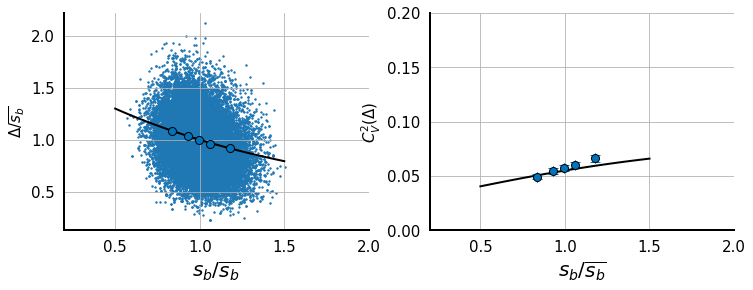

In [15]:
data2=pd.read_csv("./data/dataDSM.csv")
mn=mean_size
data2=data2[data2.time>3*doubling_time]
fig, ax = plt.subplots(1,2, figsize=(12,4))
ax[0].scatter(data2.S_b/mn,(data2.S_d-data2.S_b)/mn,s=2)


ax[0].errorbar(np.array(sb),np.array(delt),xerr=errsb,yerr=errdelt, fmt='o',mec='k',capsize=5,markersize='8',elinewidth=3,c='#0075BD')
ax[1].errorbar(np.array(sb),CV2d,xerr=errsb,yerr=errcv2d, fmt='o',mec='k',capsize=5,markersize='8',elinewidth=3,c='#0075BD')
ax[1].set_ylim([0,0.2])

ax[0].set_xlabel("$s_b/\overline{s_b}$",size=20)
ax[1].set_xlabel("$s_b/\overline{s_b}$",size=20)
ax[0].set_ylabel("$\Delta/\overline{s_b}$",size=15)
ax[1].set_ylabel("$C_V^2(\Delta)$",size=15)
for l in [0,1]:
    ax[l].set_xlim([0.2,2])
    ax[l].grid()
    ax[l].tick_params(axis='x', labelsize=15)
    ax[l].tick_params(axis='y', labelsize=15)
    for axis in ['bottom','left']:
        ax[l].spines[axis].set_linewidth(2)
        ax[l].tick_params(axis='both', width=2,length=6)
    for axis in ['top','right']:
        ax[l].spines[axis].set_linewidth(0)
        ax[l].tick_params(axis='both', width=0,length=6)
ax[0].plot(np.array(sbar)/mean_size, np.array(deltsz)/mean_size, lw=2,c='k',label="$\lambda=2$")
ax[1].plot(np.array(sbar)/mean_size, cv2sz, lw=2,c='k')

plt.savefig('./figures/div_strategy_sizerlike.eps',bbox_inches='tight')
plt.savefig('./figures/div_strategy_sizerlike.svg',bbox_inches='tight')
plt.savefig('./figures/div_strategy_sizerlike.png',bbox_inches='tight')

In [12]:
data1=pd.read_csv("./data/dataCRM.csv")
timearray=data1.time.unique()

mnszarray=[]
cvszarray=[]
errcv2sz=[]
errmnsz=[]
df=data1
del df['time']
for m in range(len(df)):    
    szs=df.loc[m, :].values.tolist()
    mean_cntr, var_cntr, std_cntr = bayesest(szs,alpha=0.95)
    mnszarray.append(np.mean(szs))
    errmnsz.append(mean_cntr[1][1]-mean_cntr[0])
    cvszarray.append(var_cntr[0]/mean_cntr[0]**2)
    errv=(var_cntr[1][1]-var_cntr[0])/mean_cntr[0]**2+2*(mean_cntr[1][1]-mean_cntr[0])*var_cntr[0]/mean_cntr[0]**3
    errcv2sz.append(errv)
    

C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:1910: RuntimeWarning: invalid value encountered in multiply
  lower_bound = self.a * scale + loc
C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:1911: RuntimeWarning: invalid value encountered in multiply
  upper_bound = self.b * scale + loc


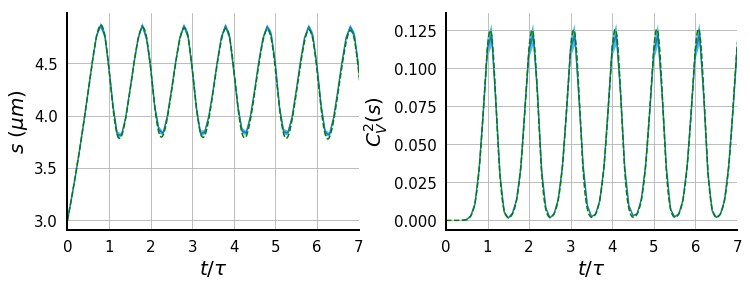

In [13]:
fig, ax = plt.subplots(1,2, figsize=(12,4))
ax[0].plot(np.array(timearray)/doubling_time,np.array(mnszarray))
ax[0].fill_between(np.array(timearray)/doubling_time,np.array(mnszarray)-np.array(errmnsz),np.array(mnszarray)+np.array(errmnsz),
                 alpha=1, edgecolor='#4db8ff', facecolor='#4db8ff',linewidth=0,label="SSA")


ax[1].plot(np.array(timearray)/doubling_time,np.array(cvszarray))
ax[1].fill_between(np.array(timearray)/doubling_time,np.array(cvszarray)-np.array(errcv2sz),np.array(cvszarray)+np.array(errcv2sz),
                 alpha=1, edgecolor='#4db8ff', facecolor='#4db8ff',linewidth=0)
ax[0].set_ylabel("$s$ $(\mu m)$",size=20)
ax[1].set_ylabel("$C_V^2(s)$",size=20)
ax[0].set_xlabel(r"$t/\tau$",size=20)
ax[1].set_xlabel(r"$t/\tau$",size=20)

for l in [0,1]:
    ax[l].set_xlim([0,7])
    taqui=np.arange(0,8,step=1)
    ax[l].set_xticks(np.array(taqui))
    ax[l].grid()
    ax[l].tick_params(axis='x', labelsize=15)
    ax[l].tick_params(axis='y', labelsize=15)
    for axis in ['bottom','left']:
        ax[l].spines[axis].set_linewidth(2)
        ax[l].tick_params(axis='both', width=2,length=6)
    for axis in ['top','right']:
        ax[l].spines[axis].set_linewidth(0)
        ax[l].tick_params(axis='both', width=0,length=6)
plt.subplots_adjust(hspace=0.3,wspace=0.3)
data=pd.read_csv("./data/dataFSP.csv")
ax[0].plot(data.time/doubling_time,data.Meansize,ls='--',c='g',label="Numeric")
ax[1].plot(data.time/doubling_time,data.VarSize/data.Meansize**2,ls='--',c='g')

plt.savefig('./figures/size_statisticssizer.svg',bbox_inches='tight')
plt.savefig('./figures/size_statisticssizer.png',bbox_inches='tight')